# Comparison of Different Regression Algorithms

In [1]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Loading Data For Each Models

In [2]:
# Load data set
df = pickle.load(open('df.pkl','rb'))
print(df.head())

            date_block_num  shop_id  item_id  item_price  item_cnt_day
date                                                                  
2013-01-01               0       18     5823      2500.0           1.0
2013-01-01               0       46     1830       599.0           3.0
2013-01-01               0       14     1830       599.0           2.0
2013-01-01               0       14     1905       249.0           1.0
2013-01-01               0       14     2808       999.0           2.0


In [3]:
# Create dataframe dictionary of all shop-item pairs up to 2015-10-31
DataFrameDict = {elem : pd.DataFrame for elem in df.item_id.unique()}

last_day = pd.DataFrame(index=['2015-10-31'])

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.item_id == key]
    DataFrameDict[key] = DataFrameDict[key].groupby(['date'])['item_cnt_day'].sum().sort_index()
    DataFrameDict[key] = DataFrameDict[key].reset_index()
    DataFrameDict[key].index = DataFrameDict[key]['date']
    DataFrameDict[key] = DataFrameDict[key].drop('date', axis=1)
    pd.to_datetime(DataFrameDict[key].index)    
    if '2015-10-31' in DataFrameDict[key].index:
        pass
    else: 
        DataFrameDict[key] = DataFrameDict[key].append(last_day)
    DataFrameDict[key] = DataFrameDict[key].asfreq('D').fillna(0)
    print(DataFrameDict[key].tail(1))

            item_cnt_day
date                    
2015-10-31          10.0
            item_cnt_day
2015-10-31           0.0
            item_cnt_day
date                    
2015-10-31           2.0
            item_cnt_day
date                    
2015-10-31           2.0
            item_cnt_day
date                    
2015-10-31          15.0
            item_cnt_day
date                    
2015-10-31           6.0
            item_cnt_day
2015-10-31           0.0
            item_cnt_day
date                    
2015-10-31           2.0
            item_cnt_day
date                    
2015-10-31          11.0
            item_cnt_day
date                    
2015-10-31          28.0
            item_cnt_day
2015-10-31           0.0
            item_cnt_day
2015-10-31           0.0
            item_cnt_day
date                    
2015-10-31           1.0
            item_cnt_day
2015-10-31           0.0
            item_cnt_day
date                    
2015-10-31           7.0


### Prepare data for random forest and gradient boosting

In [4]:
aggregation = {'item_price':'mean',
               'item_cnt_day':'sum'}

train_model = df.groupby(['date_block_num','shop_id','item_id']).agg(aggregation)
train_model = train_model.reset_index()
train_model.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2,1905,249.000000,3.0
1,0,2,1916,249.000000,3.0
2,0,2,2308,799.000000,3.0
3,0,2,2416,449.000000,1.0
4,0,2,2808,998.981481,17.0


In [5]:
df_pivot = pd.pivot_table(data=pd.DataFrame(train_model),index=['shop_id','item_id'], 
                           columns=['date_block_num'], values=['item_cnt_day','item_price'])
df_pivot = df_pivot.reset_index()

print(df_pivot.head())
print(len(df_pivot))

               shop_id item_id item_cnt_day                                \
date_block_num                            0    1    2    3    4    5    6   
0                    2    1495          NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1                    2    1830          NaN  NaN  3.0  2.0  3.0  2.0  2.0   
2                    2    1855          NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                    2    1905          3.0  NaN  NaN  2.0  NaN  3.0  2.0   
4                    2    1916          3.0  2.0  2.0  2.0  2.0  NaN  2.0   

                    ... item_price                                       \
date_block_num    7 ...         24       25     26     27     28     29   
0               NaN ...        NaN      NaN    NaN  499.0    NaN    NaN   
1               7.0 ...        NaN      NaN    NaN    NaN    NaN    NaN   
2               NaN ...      799.0  627.825  399.5    NaN    NaN    NaN   
3               1.0 ...      249.0  249.000  249.0  249.0  249.0  249.0   
4         

In [6]:
df_index = df_pivot[['shop_id','item_id']]

df_sales = df_pivot.loc[:,['item_cnt_day']]
df_sales = df_sales.fillna(0)
df_index.columns = df_index.columns.get_level_values(0)
df_sales.columns = df_sales.columns.get_level_values(1)
df_sales = pd.merge(df_index, df_sales, on=df_index.index).drop('key_0', axis=1)

df_price = df_pivot.loc[:,['item_price']]
df_index.columns = df_index.columns.get_level_values(0)
df_price.columns = df_price.columns.get_level_values(1)
df_price = pd.merge(df_index, df_price, on=df_index.index).drop('key_0', axis=1)

In [7]:
# Filling nan values with back filling on earlier months and forward filling on later months
dT_price = df_price.transpose()
df_price = dT_price.fillna(method='bfill').fillna(method='ffill')
df_price = df_price.transpose()
df_price.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2.0,1495.0,632.333333,632.333333,632.333333,632.333333,632.333333,632.333333,632.333333,632.333333,...,499.0,499.000,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0
1,2.0,1830.0,449.250000,449.250000,449.250000,599.000000,599.000000,599.000000,399.560000,315.568750,...,599.0,599.000,599.0,599.0,599.0,599.0,599.0,599.0,599.0,599.0
2,2.0,1855.0,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,...,799.0,627.825,399.5,399.0,399.0,399.0,399.0,399.0,399.0,399.0
3,2.0,1905.0,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,...,249.0,249.000,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0
4,2.0,1916.0,249.000000,249.000000,249.000000,249.000000,224.000000,249.000000,249.000000,249.000000,...,249.0,249.000,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0


In [8]:
melt_sales = df_sales.melt(id_vars=['shop_id','item_id'], var_name='Month', value_name='Sales')

melt_prices = df_price.melt(id_vars=['shop_id','item_id'], var_name='Month', value_name='Prices')

melt = melt_sales.join(melt_prices['Prices'], on=melt_sales.index)
melt.head()

,shop_id,item_id,Month,Sales,Prices
0,2,1495,0,0.0,632.333333
1,2,1830,0,0.0,449.250000
2,2,1855,0,0.0,1199.000000
3,2,1905,0,3.0,249.000000
4,2,1916,0,3.0,249.000000


In [9]:
melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 5 columns):
shop_id    65246 non-null int64
item_id    65246 non-null int64
Month      65246 non-null object
Sales      65246 non-null float64
Prices     65246 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.5+ MB


In [10]:
# Convert Month feature from string to numerical
melt['Month'] = melt['Month'].astype(int)
melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 5 columns):
shop_id    65246 non-null int64
item_id    65246 non-null int64
Month      65246 non-null int64
Sales      65246 non-null float64
Prices     65246 non-null float64
dtypes: float64(2), int64(3)
memory usage: 2.5 MB


In [11]:
# Create additional features: lagged sales and prices, sales and price differences, and percentage change on price.
melt['Last_Month_Sales'] = melt.groupby(['shop_id','item_id',])['Sales'].shift()
melt['Last-1_Month_Sales'] = melt.groupby(['shop_id','item_id',])['Sales'].shift(2)
melt['Last-2_Month_Sales'] = melt.groupby(['shop_id','item_id',])['Sales'].shift(3)

melt['Last_Month_Diff'] = melt.groupby(['shop_id','item_id',])['Last_Month_Sales'].diff()
melt['Last-1_Month_Diff'] = melt.groupby(['shop_id','item_id',])['Last-1_Month_Sales'].diff()

melt['Price_Diff'] = melt.groupby(['item_id','shop_id'])['Prices'].diff()
melt['Last_Month_Prices'] = melt.groupby(['shop_id','item_id',])['Prices'].shift()
melt['Last-1_Month_Prices'] = melt.groupby(['shop_id','item_id',])['Prices'].shift(2)

melt['Price_pct_change'] = melt['Price_Diff']/melt['Prices']*100

melt = melt.dropna()
melt.head()

,shop_id,item_id,Month,Sales,Prices,Last_Month_Sales,Last-1_Month_Sales,Last-2_Month_Sales,Last_Month_Diff,Last-1_Month_Diff,Price_Diff,Last_Month_Prices,Last-1_Month_Prices,Price_pct_change
5757,2,1495,3,0.0,632.333333,0.0,0.0,0.0,0.0,0.0,0.00,632.333333,632.333333,0.0
5758,2,1830,3,2.0,599.000000,3.0,0.0,0.0,3.0,0.0,149.75,449.250000,449.250000,25.0
5759,2,1855,3,0.0,1199.000000,0.0,0.0,0.0,0.0,0.0,0.00,1199.000000,1199.000000,0.0
5760,2,1905,3,2.0,249.000000,0.0,0.0,3.0,0.0,-3.0,0.00,249.000000,249.000000,0.0
5761,2,1916,3,2.0,249.000000,2.0,2.0,3.0,0.0,-1.0,0.00,249.000000,249.000000,0.0


In [12]:
# Create training and test data
train = melt[melt['Month'] < 33]
test = melt[melt['Month'] == 33]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

### Prepare data for SARIMA model forecasting

In [13]:
# Resamlpe data by monthly frequency
total_annaul_data = {elem : pd.DataFrame for elem in df.item_id.unique()}
total_annaul_train = {elem : pd.DataFrame for elem in df.item_id.unique()}
total_annaul_test = {elem : pd.DataFrame for elem in df.item_id.unique()}

for key in total_annaul_data.keys():
    total_annaul_data[key] = DataFrameDict[key].resample('M').sum()
    total_annaul_train[key] = total_annaul_data[key]['item_cnt_day'][:-1]
    total_annaul_test[key] = total_annaul_data[key]['item_cnt_day'][-1:]

### Prepare data for Facebook Prophet model forecasting

In [14]:
# Rename dataframe with 'ds' and 'y'
df_FP = {elem : pd.DataFrame for elem in df.item_id.unique()}

for key in DataFrameDict.keys():
    df_FP[key] = DataFrameDict[key].loc[DataFrameDict[key].index < '2015-10-01']
    df_FP[key] = df_FP[key].reset_index().rename(index=str, columns={"date": "ds", "index": "ds", "item_cnt_day":'y'})

### Load store-item weight data and hold out set for evaluation

In [15]:
df_weight = pickle.load(open('weight.pkl','rb'))
df_hold = pickle.load(open('df_hold.pkl','rb'))

### Define validation fuctions

In [125]:
from sklearn.metrics import mean_squared_error, r2_score

def rms(y_test, y_pred):
    return sqrt(mean_squared_error(y_test, y_pred))

def r2(y_test, y_pred):
    return r2_score(y_test, y_pred)

def Model_evaluate(model):
    r2_score = round(r2(model['item_cnt'], model['Prediction_shop']), 3)
    rms_error = round(rms(model['item_cnt'], model['Prediction_shop']), 3)
    print("R2 score: %.3f" %r2_score)
    print("Mean squared error: %.3f" %rms_error)
    
    fs = 15
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,5))
    x = np.array(model['item_cnt'])
    y = np.array(model['Prediction_shop'])

    ax1 = plt.subplot(1, 3, 1)
    ax1.scatter(x, y, s=5, alpha=0.3)
    ax1.set_title('Prediction vs Sales, (%i data points)' % len(model), size=fs)
    ax1.set_xlabel('Sales', size=fs)
    ax1.set_ylabel('Prediction', size=fs)
    ax1.set_xlim(-100,2300)
    ax1.set_ylim(-100,2300)
    ax1.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

    ax2 = plt.subplot(1, 3, 2)
    ax2.scatter(x, y, s=5, alpha=0.3)
    ax2.set_title('Prediction vs Sales (zoom in)', size=fs)
    ax2.set_xlabel('Sales', size=fs)
    ax2.set_xlim(-20,500)
    ax2.set_ylim(-20,500)
    ax2.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

    ax3 = plt.subplot(1, 3, 3)
    ax3.scatter(x, y, s=5, alpha=0.3)
    ax3.set_title('Prediction vs Sales (zoom in)', size=fs)
    ax3.set_xlabel('Sales', size=fs)
    ax3.set_xlim(-10,50)
    ax3.set_ylim(-10,50)
    ax3.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

    plt.show()

## Baseline Model

In [47]:
val = test['Sales'].values
p = test['Last_Month_Sales'].values

error = rms(val, p)
abs_error = mean(abs(val - p))
error_r2 = r2(val, p)
#percent_error = (abs_error / yts).mean()    

print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (33, error, abs_error, error_r2))

Month 33 - RMS 47.518 	 Absolute Error 3.165 	 R2 0.29


In [96]:
Baseline_evaluate = pd.merge(df_hold, test[['shop_id','item_id','Last_Month_Sales']],  how='left', left_on=['shop_id','item_id'], 
                       right_on = ['shop_id','item_id']).fillna(0)
Baseline_evaluate = Baseline_evaluate.rename(index=str, columns={'Last_Month_Sales':'Prediction_shop'})

Baseline_evaluate.head()

,shop_id,item_id,item_cnt,Prediction_shop
0,2,2269,4.0,1.0
1,2,2445,1.0,0.0
2,2,2808,1.0,1.0
3,2,3341,4.0,7.0
4,2,3343,2.0,4.0


R2 score: 0.289
Mean squared error: 64.996


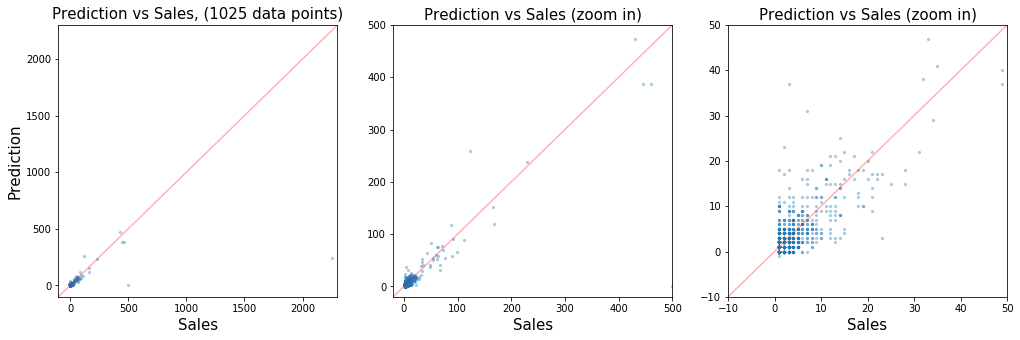

In [126]:
Model_evaluate(Baseline_evaluate)

Looks like there are two store-item pairs that have large spikes of sales in Oct 2015.

In [98]:
Baseline_evaluate.loc[Baseline_evaluate['item_cnt'] >= 500]

,shop_id,item_id,item_cnt,Prediction_shop
182,12,11373,2253.0,246.0
184,12,20949,500.0,0.0


In [99]:
Baseline_evaluate_trimmed = Baseline_evaluate[Baseline_evaluate.item_cnt < 500]

R2 score: 0.936
Mean squared error: 7.129


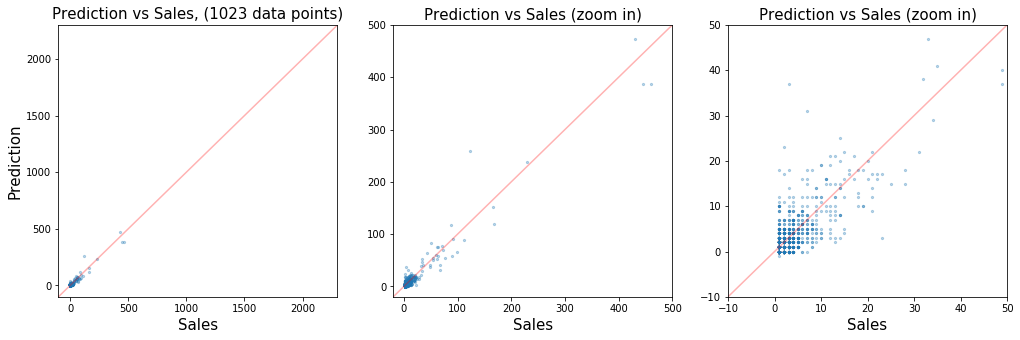

In [127]:
Model_evaluate(Baseline_evaluate_trimmed)

By removing the two rows, we can see the high accuracy of baseline model meaning that the rest of sales data are fairly consistent from September to October.

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor
RFR = pickle.load(open("RFR_final.pkl", "rb"))

In [21]:
%%time

RFR.fit(xtr, ytr)
p_RFR = RFR.predict(xts)

abs_error = mean(abs(yts - p_RFR))
error_r2 = r2(yts, p_RFR)
   
error = rms(yts, p_RFR)
print('Month 33 - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (error, abs_error, error_r2))

Month 33 - RMS 49.092 	 Absolute Error 3.179 	 R2 0.25
CPU times: user 22.1 s, sys: 187 ms, total: 22.3 s
Wall time: 6.08 s


In [22]:
# Merge predicted data back to the test set
df_RFR = xts
df_RFR['Prediction_shop'] = np.round(p_RFR)
df_RFR.head()

,shop_id,item_id,Month,Prices,Last_Month_Sales,Last-1_Month_Sales,Last-2_Month_Sales,Last_Month_Diff,Last-1_Month_Diff,Price_Diff,Last_Month_Prices,Last-1_Month_Prices,Price_pct_change,Prediction_shop
63327,2,1495,33,499.0,0.0,2.0,0.0,-2.0,2.0,0.0,499.0,499.0,0.0,1.0
63328,2,1830,33,599.0,0.0,0.0,0.0,0.0,0.0,0.0,599.0,599.0,0.0,0.0
63329,2,1855,33,399.0,1.0,0.0,0.0,1.0,0.0,0.0,399.0,399.0,0.0,0.0
63330,2,1905,33,249.0,0.0,0.0,1.0,0.0,-1.0,0.0,249.0,249.0,0.0,1.0
63331,2,1916,33,249.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,249.0,0.0,0.0


In [23]:
# Merge random forest prediction to hold out set
RF_evaluate = pd.merge(df_hold, df_RFR[['shop_id','item_id','Prediction_shop']],  how='left', left_on=['shop_id','item_id'], 
                       right_on = ['shop_id','item_id']).fillna(0)
RF_evaluate.head()

,shop_id,item_id,item_cnt,Prediction_shop
0,2,2269,4.0,1.0
1,2,2445,1.0,1.0
2,2,2808,1.0,1.0
3,2,3341,4.0,6.0
4,2,3343,2.0,6.0


R2 score: 0.241
Mean squared error: 67.144


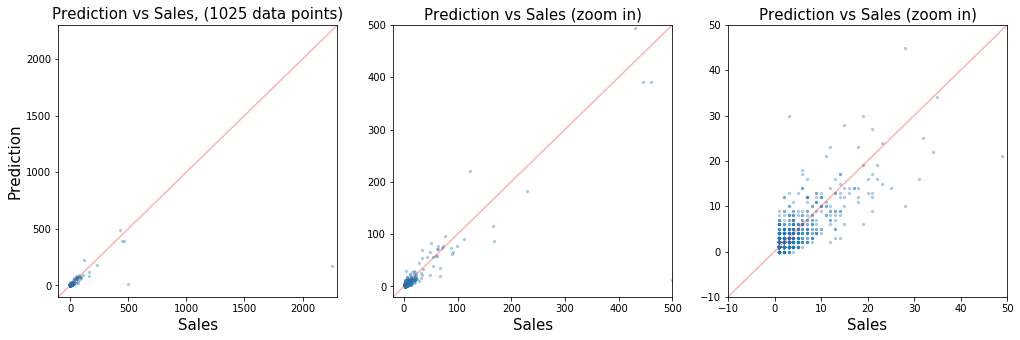

In [128]:
Model_evaluate(RF_evaluate)

## Gradient Boosting

In [25]:
GBR = pickle.load(open("GBR_final.pkl", "rb"))

In [26]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

GBR.fit(xtr, ytr)
p_GBR = GBR.predict(xts)

abs_error = mean(abs(yts - p_GBR))
error_r2 = r2(yts, p_GBR)
 
error = rms(yts, p_GBR)
print('Month 33 - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (error, abs_error, error_r2))

Month 33 - RMS 48.220 	 Absolute Error 3.602 	 R2 0.27
CPU times: user 2.46 s, sys: 27.1 ms, total: 2.49 s
Wall time: 2.49 s


In [27]:
# Merge predicted data back to the test set
df_GBR = xts
df_GBR['Prediction_shop'] = np.round(p_GBR)
df_GBR.head()

,shop_id,item_id,Month,Prices,Last_Month_Sales,Last-1_Month_Sales,Last-2_Month_Sales,Last_Month_Diff,Last-1_Month_Diff,Price_Diff,Last_Month_Prices,Last-1_Month_Prices,Price_pct_change,Prediction_shop
63327,2,1495,33,499.0,0.0,2.0,0.0,-2.0,2.0,0.0,499.0,499.0,0.0,1.0
63328,2,1830,33,599.0,0.0,0.0,0.0,0.0,0.0,0.0,599.0,599.0,0.0,1.0
63329,2,1855,33,399.0,1.0,0.0,0.0,1.0,0.0,0.0,399.0,399.0,0.0,1.0
63330,2,1905,33,249.0,0.0,0.0,1.0,0.0,-1.0,0.0,249.0,249.0,0.0,1.0
63331,2,1916,33,249.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,249.0,0.0,1.0


In [28]:
# Merge random forest prediction to hold out set
GBR_evaluate = pd.merge(df_hold, df_GBR[['shop_id','item_id','Prediction_shop']],  how='left', left_on=['shop_id','item_id'], 
                       right_on = ['shop_id','item_id']).fillna(0)
GBR_evaluate.head()

,shop_id,item_id,item_cnt,Prediction_shop
0,2,2269,4.0,1.0
1,2,2445,1.0,1.0
2,2,2808,1.0,2.0
3,2,3341,4.0,6.0
4,2,3343,2.0,3.0


R2 score: 0.268
Mean squared error: 65.927


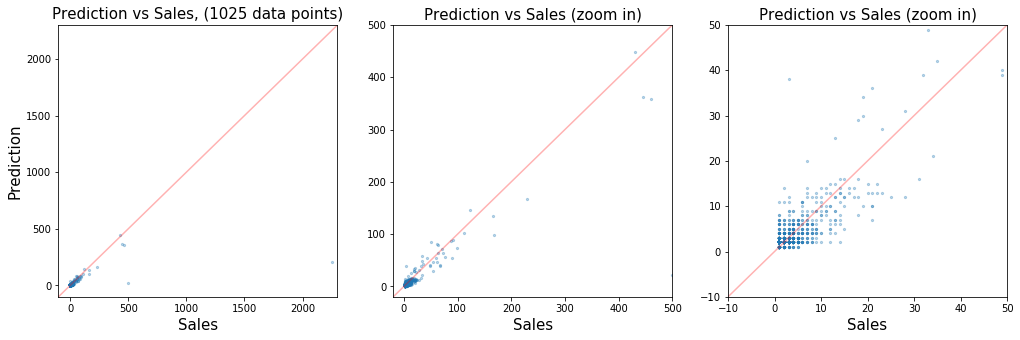

In [129]:
Model_evaluate(GBR_evaluate)

## SARIMA (Seasonal AutoRegressive Integrated Moving Average)

In [30]:
# Load SARIMA's parameteres for each unique item
top_model = pickle.load(open('top_model_SARIMAX.pkl','rb'))

In [31]:
#Store model information into dictionaries for model prediction
import re
from statsmodels.tsa.statespace.sarimax import SARIMAX

#(p,d,q), (P,D,Q,m)
order_term = {elem : pd.DataFrame for elem in top_model.keys()}
sorder_term = {elem : pd.DataFrame for elem in top_model.keys()}
t_term = {elem : pd.DataFrame for elem in top_model.keys()}
trend_seek = re.compile('[a-z]{1,2}')

for key in top_model.keys():
    order_term[key] = (int(top_model[key][2]),int(top_model[key][5]),int(top_model[key][8]))
    sorder_term[key] = (int(top_model[key][13]),int(top_model[key][16]),int(top_model[key][19]),int(top_model[key][22]))
    t_term[key] = (trend_seek.findall(top_model[key]))[0]

In [32]:
%%time
# Forecast Oct sales with SARIMAX
SA_pred = pd.DataFrame(index=['Prediction'], columns=None)
for key in total_annaul_train.keys():
    # define model
    model = SARIMAX(total_annaul_train[key], order=order_term[key], seasonal_order=sorder_term[key], trend=t_term[key], enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict('2015-10-31')
    #df['item_id'].append(key)
    SA_pred[key] = yhat[0]
SA_pred

CPU times: user 8.64 s, sys: 418 ms, total: 9.06 s
Wall time: 7 s


In [33]:
# Transpose data to merge with store-item weights
df_t = SA_pred.T
df_t = df_t.reset_index().rename(index=str, columns={"index": "item_id"})
df_t.head()

,item_id,Prediction
0,5823,155.618696
1,1830,1.391329
2,1905,18.793294
3,2808,-36.770642
4,22088,124.805050


In [34]:
# Merge SARIMA forecast with store-item weights
df_SA = pd.merge(df_weight, df_t, on='item_id')
df_SA['Prediction_shop'] = round(df_SA['weight'] * df_SA['Prediction'])
df_SA = df_SA.drop('item_cnt',axis=1)
print(df_SA.head())
print(len(df_SA))

   shop_id  item_id    weight  Prediction  Prediction_shop
0        2     2269  0.019608   52.196181              1.0
1        3     2269  0.019608   52.196181              1.0
2        5     2269  0.019608   52.196181              1.0
3        6     2269  0.019608   52.196181              1.0
4        7     2269  0.039216   52.196181              2.0
1163


In [35]:
# Merge forecast with hold out set
SA_evaluate = pd.merge(df_hold, df_SA,  how='left', left_on=['shop_id','item_id'], 
                           right_on = ['shop_id','item_id']).fillna(0)
SA_evaluate.head()

,shop_id,item_id,item_cnt,weight,Prediction,Prediction_shop
0,2,2269,4.0,0.019608,52.196181,1.0
1,2,2445,1.0,0.000000,0.000000,0.0
2,2,2808,1.0,0.031250,-36.770642,-1.0
3,2,3341,4.0,0.031250,256.780280,8.0
4,2,3343,2.0,0.018868,306.975805,6.0


R2 score: 0.380
Mean squared error: 60.707


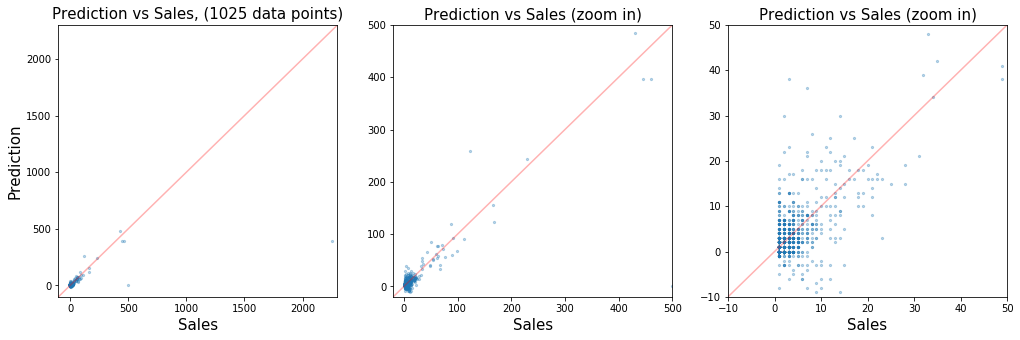

In [130]:
Model_evaluate(SA_evaluate)

## Facebook Prophet

In [37]:
# Load Prophet's parameteres for each unique item. 
FP_model = pickle.load(open('FP_model.pkl','rb'))

In [38]:
# First term is weekly seasonaliy, second term is yearly seasonality, and third term is growth
FP_model

{1495: [False, False, 'logistic'],
 1830: [False, False, 'logistic'],
 1855: [False, False, 'logistic'],
 1905: [False, False, 'linear'],
 1916: [False, False, 'linear'],
 2269: [False, False, 'linear'],
 2308: [False, True, 'logistic'],
 2416: [False, False, 'linear'],
 2445: [False, False, 'linear'],
 2753: [True, True, 'linear'],
 2808: [False, False, 'logistic'],
 3329: [False, False, 'linear'],
 3331: [False, False, 'linear'],
 3340: [False, False, 'logistic'],
 3341: [False, False, 'linear'],
 3343: [False, False, 'linear'],
 3731: [False, False, 'logistic'],
 3732: [False, False, 'logistic'],
 3733: [False, False, 'linear'],
 3734: [False, False, 'linear'],
 3928: [False, False, 'logistic'],
 4178: [False, True, 'linear'],
 4181: [False, False, 'linear'],
 4870: [False, True, 'logistic'],
 5272: [False, False, 'linear'],
 5672: [False, False, 'linear'],
 5821: [False, True, 'linear'],
 5822: [False, True, 'linear'],
 5823: [True, True, 'linear'],
 6457: [False, True, 'linear'],


In [39]:
%%time
# Fit parameters into model and make predictions
from fbprophet import Prophet

FP_pred = {elem : pd.DataFrame for elem in df_FP.keys()}

for key in df_FP.keys():
    if df_FP[key]['y'][-120:-30].max() == 0:
        df_FP[key]['cap'] = 1
    else:
            df_FP[key]['cap'] = df_FP[key]['y'][-120:-30].max()
    m_pro = Prophet(daily_seasonality=False, weekly_seasonality=FP_model[key][0], 
                    yearly_seasonality=FP_model[key][1], growth=FP_model[key][2])
    m_pro.fit(df_FP[key])
    m_future = m_pro.make_future_dataframe(periods=31)
    m_future['cap'] = df_FP[key]['y'][-120:-30].max()
    m_future['floor'] = 0
    forecast = m_pro.predict(m_future)
    FP_pred[key] = forecast[['ds','yhat']].tail(31)

CPU times: user 2min 21s, sys: 4.57 s, total: 2min 26s
Wall time: 2min 5s


In [40]:
# Convert the dictionary of predictions into one dataframe
for key in FP_pred.keys():
    FP_pred[key]['item_id'] = key
    
FP_pred = pd.concat([df for df in FP_pred.values()], ignore_index=True)
FP_pred = pd.DataFrame(FP_pred.groupby(['item_id'])['yhat'].sum())
print(FP_pred.head())

              yhat
item_id           
1495      1.884186
1830      4.205387
1855      0.000000
1905     47.898988
1916     13.685403


In [41]:
# Merge store-item weights with item count
FP_evaluate = pd.merge(df_weight, FP_pred, on='item_id')
FP_evaluate = FP_evaluate.rename(index=str, columns={"yhat": "Prediction"})
FP_evaluate.head()

,shop_id,item_id,item_cnt,weight,Prediction
0,2,2269,1.0,0.019608,39.192777
1,3,2269,1.0,0.019608,39.192777
2,5,2269,1.0,0.019608,39.192777
3,6,2269,1.0,0.019608,39.192777
4,7,2269,2.0,0.039216,39.192777


In [42]:
# Calculate store-item count from forecasted data
FP_evaluate['Prediction_shop'] = round(FP_evaluate['weight'] * FP_evaluate['Prediction'])
FP_evaluate = FP_evaluate.drop('item_cnt',axis=1)
print(FP_evaluate.head())

   shop_id  item_id    weight  Prediction  Prediction_shop
0        2     2269  0.019608   39.192777              1.0
1        3     2269  0.019608   39.192777              1.0
2        5     2269  0.019608   39.192777              1.0
3        6     2269  0.019608   39.192777              1.0
4        7     2269  0.039216   39.192777              2.0


In [43]:
FP_evaluate = pd.merge(df_hold, FP_evaluate,  how='left', left_on=['shop_id','item_id'], 
                       right_on = ['shop_id','item_id']).fillna(0)
FP_evaluate.head()

,shop_id,item_id,item_cnt,weight,Prediction,Prediction_shop
0,2,2269,4.0,0.019608,39.192777,1.0
1,2,2445,1.0,0.000000,0.000000,0.0
2,2,2808,1.0,0.031250,47.143399,1.0
3,2,3341,4.0,0.031250,304.111932,10.0
4,2,3343,2.0,0.018868,274.117766,5.0


R2 score: 0.312
Mean squared error: 63.910


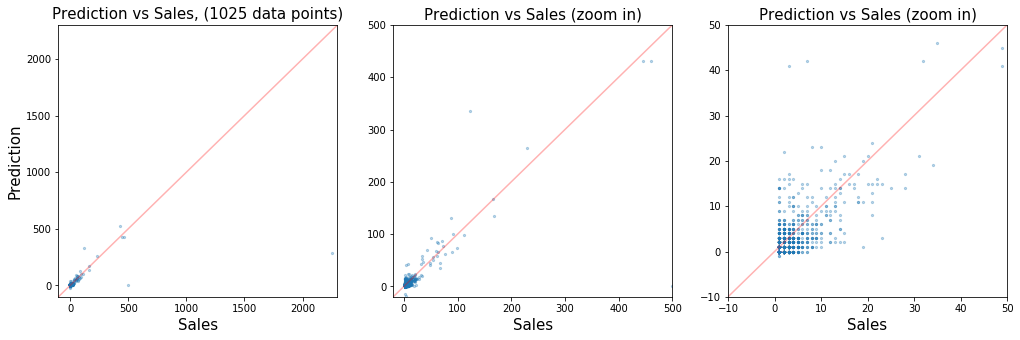

In [131]:
Model_evaluate(FP_evaluate)

### Compare All Four Models

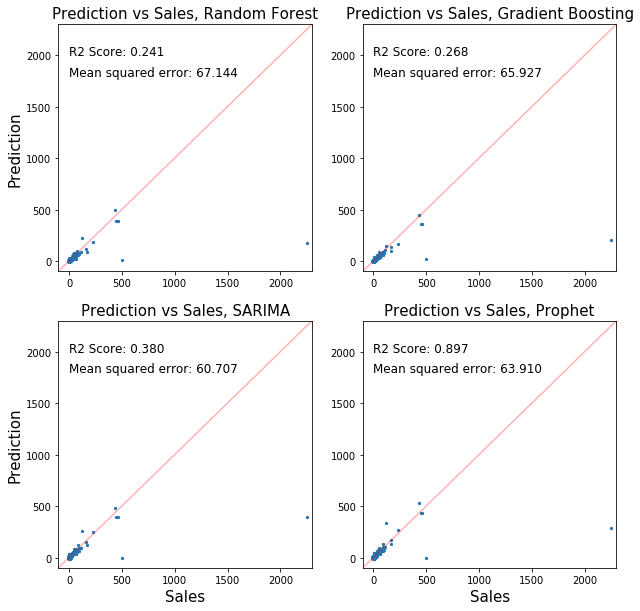

In [154]:
r2_RF = round(r2(RF_evaluate['item_cnt'], RF_evaluate['Prediction_shop']), 3)
r2_GBR = round(r2(GBR_evaluate['item_cnt'], GBR_evaluate['Prediction_shop']), 3)
r2_SA = round(r2(SA_evaluate['item_cnt'], SA_evaluate['Prediction_shop']), 3)
r2_FP = round(r2(FP_evaluate_trimmed['item_cnt'], FP_evaluate_trimmed['Prediction_shop']), 3)

rms_RF = round(rms(RF_evaluate['item_cnt'], RF_evaluate['Prediction_shop']), 3)
rms_GBR = round(rms(GBR_evaluate['item_cnt'], GBR_evaluate['Prediction_shop']), 3)
rms_SA = round(rms(SA_evaluate['item_cnt'], SA_evaluate['Prediction_shop']), 3)
rms_FP = round(rms(FP_evaluate['item_cnt'], FP_evaluate['Prediction_shop']), 3)

fs = 15
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(10,10))

ax1 = plt.subplot(2, 2, 1)
ax1.scatter(RF_evaluate['item_cnt'], RF_evaluate['Prediction_shop'], s=5)
ax1.set_title('Prediction vs Sales, Random Forest', size=fs)
ax1.set_ylabel('Prediction', size=fs)
ax1.set_xlim(-100,2300)
ax1.set_ylim(-100,2300)
plt.text(1, 2000, "R2 Score: %.3f" % r2_RF, size=12)
plt.text(1, 1800, "Mean squared error: %.3f" %rms_RF, size=12)
ax1.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(GBR_evaluate['item_cnt'], GBR_evaluate['Prediction_shop'], s=5)
ax2.set_title('Prediction vs Sales, Gradient Boosting', size=fs)
ax2.set_xlim(-100,2300)
ax2.set_ylim(-100,2300)
plt.text(1, 2000, "R2 Score: %.3f" % r2_GBR, size=12)
plt.text(1, 1800, "Mean squared error: %.3f" %rms_GBR, size=12)
ax2.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(SA_evaluate['item_cnt'], SA_evaluate['Prediction_shop'], s=5)
ax3.set_title('Prediction vs Sales, SARIMA', size=fs)
ax3.set_ylabel('Prediction', size=fs)
ax3.set_xlabel('Sales', size=fs)
ax3.set_xlim(-100,2300)
ax3.set_ylim(-100,2300)
plt.text(1, 2000, "R2 Score: %.3f" % r2_SA, size=12)
plt.text(1, 1800, "Mean squared error: %.3f" %rms_SA, size=12)
ax3.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

ax4 = plt.subplot(2, 2, 4)
ax4.scatter(FP_evaluate['item_cnt'], FP_evaluate['Prediction_shop'], s=5)
ax4.set_title('Prediction vs Sales, Prophet', size=fs)
ax4.set_xlabel('Sales', size=fs)
ax4.set_xlim(-100,2300)
ax4.set_ylim(-100,2300)
plt.text(1, 2000, "R2 Score: %.3f" % r2_FP, size=12)
plt.text(1, 1800, "Mean squared error: %.3f" %rms_FP, size=12)
ax4.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

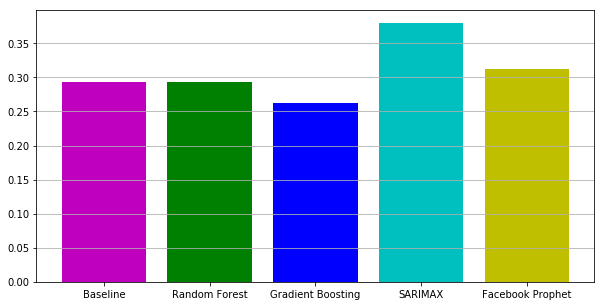

In [50]:
models = pd.DataFrame({'model':['Baseline','Random Forest','Gradient Boosting','SARIMAX', 'Facebook Prophet'], 'R2 Score':[0.289,0.241,0.268,0.380,0.312]})

plt.subplots(figsize=(10,5))
plt.bar(models['model'], models['R2 Score'], color=['m','g','b','c','y'])
plt.grid(True, axis='y')
plt.show()

From the chart of R2 scores above, it shows that SARIMAX model has the highest accuracy compared to the other models.


Interestingly, only SARIMA and Facebook Prophet models performed better than the baseline model despite both random forest and gradient boosting use more features in building the models. The performances of all models are much lower than their predictions of August and September sales. This is due to the two store-item pairs that all models failed to make accurate predictions. One of them is a single store has sold more than 2000 units of a single item and all models have made predictions of less than 500. And the other one has sold 500 units which all models have made predictions below 30. 

Let's see how the models perform without the two unexpected sale spikes.

In [101]:
# All of the models stumble on the same abnormal sales spikes
print(RF_evaluate.loc[RF_evaluate['item_cnt'] >= 500])
print(GBR_evaluate.loc[GBR_evaluate['item_cnt'] >= 500])
print(SA_evaluate.loc[SA_evaluate['item_cnt'] >= 500])
print(FP_evaluate.loc[FP_evaluate['item_cnt'] >= 500])

     shop_id  item_id  item_cnt  Prediction_shop
182       12    11373    2253.0            172.0
184       12    20949     500.0             12.0
     shop_id  item_id  item_cnt  Prediction_shop
182       12    11373    2253.0            208.0
184       12    20949     500.0             22.0
     shop_id  item_id  item_cnt  weight  Prediction  Prediction_shop
182       12    11373    2253.0     1.0  390.703584            391.0
184       12    20949     500.0     0.0    0.000000              0.0
     shop_id  item_id  item_cnt  weight  Prediction  Prediction_shop
182       12    11373    2253.0     1.0  289.658529            290.0
184       12    20949     500.0     0.0    0.000000              0.0


In [102]:
RF_evaluate_trimmed = RF_evaluate[RF_evaluate.item_cnt < 500]
GBR_evaluate_trimmed = GBR_evaluate[GBR_evaluate.item_cnt < 500]
SA_evaluate_trimmed = SA_evaluate[SA_evaluate.item_cnt < 500]
FP_evaluate_trimmed = FP_evaluate[FP_evaluate.item_cnt < 500]

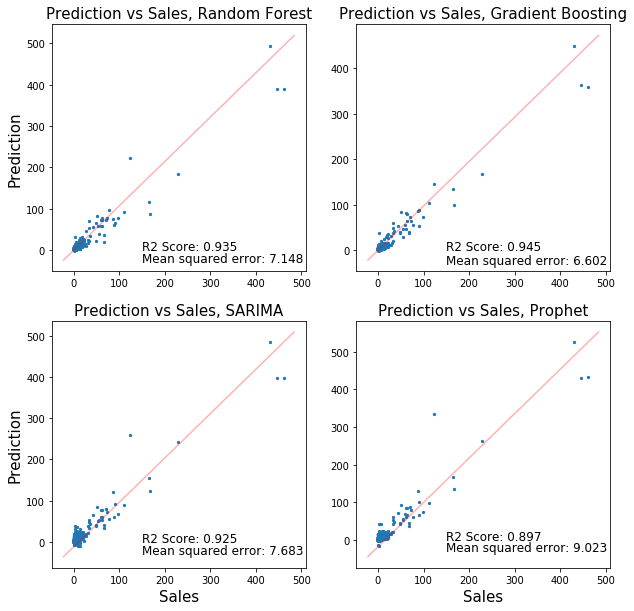

In [164]:
r2_RF = round(r2(RF_evaluate_trimmed['item_cnt'], RF_evaluate_trimmed['Prediction_shop']), 3)
r2_GBR = round(r2(GBR_evaluate_trimmed['item_cnt'], GBR_evaluate_trimmed['Prediction_shop']), 3)
r2_SA = round(r2(SA_evaluate_trimmed['item_cnt'], SA_evaluate_trimmed['Prediction_shop']), 3)
r2_FP = round(r2(FP_evaluate_trimmed['item_cnt'], FP_evaluate_trimmed['Prediction_shop']), 3)

rms_RF = round(rms(RF_evaluate_trimmed['item_cnt'], RF_evaluate_trimmed['Prediction_shop']), 3)
rms_GBR = round(rms(GBR_evaluate_trimmed['item_cnt'], GBR_evaluate_trimmed['Prediction_shop']), 3)
rms_SA = round(rms(SA_evaluate_trimmed['item_cnt'], SA_evaluate_trimmed['Prediction_shop']), 3)
rms_FP = round(rms(FP_evaluate_trimmed['item_cnt'], FP_evaluate_trimmed['Prediction_shop']), 3)

fs = 15
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(10,10))

ax1 = plt.subplot(2, 2, 1)
ax1.scatter(RF_evaluate_trimmed['item_cnt'], RF_evaluate_trimmed['Prediction_shop'], s=5)
ax1.set_title('Prediction vs Sales, Random Forest', size=fs)
ax1.set_ylabel('Prediction', size=fs)
plt.text(150, 0, "R2 Score: %.3f" % r2_RF, size=12)
plt.text(150, -30, "Mean squared error: %.3f" %rms_RF, size=12)
ax1.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(GBR_evaluate_trimmed['item_cnt'], GBR_evaluate_trimmed['Prediction_shop'], s=5)
ax2.set_title('Prediction vs Sales, Gradient Boosting', size=fs)
plt.text(150, 0, "R2 Score: %.3f" % r2_GBR, size=12)
plt.text(150, -30, "Mean squared error: %.3f" %rms_GBR, size=12)
ax2.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(SA_evaluate_trimmed['item_cnt'], SA_evaluate_trimmed['Prediction_shop'], s=5)
ax3.set_title('Prediction vs Sales, SARIMA', size=fs)
ax3.set_ylabel('Prediction', size=fs)
ax3.set_xlabel('Sales', size=fs)
plt.text(150, 0, "R2 Score: %.3f" % r2_SA, size=12)
plt.text(150, -30, "Mean squared error: %.3f" %rms_SA, size=12)
ax3.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

ax4 = plt.subplot(2, 2, 4)
ax4.scatter(FP_evaluate_trimmed['item_cnt'], FP_evaluate_trimmed['Prediction_shop'], s=5)
ax4.set_title('Prediction vs Sales, Prophet', size=fs)
ax4.set_xlabel('Sales', size=fs)
plt.text(150, 0, "R2 Score: %.3f" % r2_FP, size=12)
plt.text(150, -30, "Mean squared error: %.3f" %rms_FP, size=12)
ax4.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)

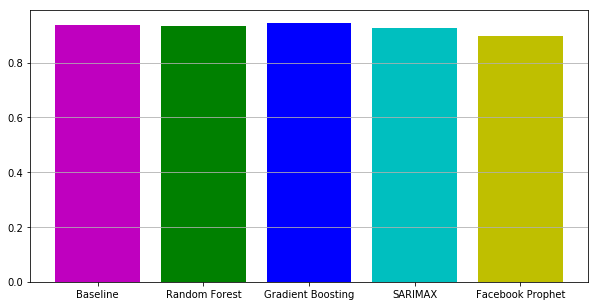

In [107]:
models = pd.DataFrame({'model':['Baseline','Random Forest','Gradient Boosting','SARIMAX', 'Facebook Prophet'], 'R2 Score':[0.936,0.935,0.945,0.925,0.897]})

plt.subplots(figsize=(10,5))
plt.bar(models['model'], models['R2 Score'], color=['m','g','b','c','y'])
plt.grid(True, axis='y')
plt.show()

After removing these two abnormal records, all models including baseline have very high R2 score on the rest of the predictions on sales data of Oct 2015. And surprisingly, the actually performed almost no better than the baseline model. 

This is explainable for both random forest and gradient boosting models, which last month sales is the feature with importance has higher importance than all other features combined. Therefore, it makes sense that these two models would mimic baseline model based on feature importance.